#  Modelling Uncertainity with Housing Data

In [31]:
#@title Import { display-mode: "form" }

import pandas as pd
from pprint import pprint
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

import tensorflow.compat.v2 as tf
tf.enable_v2_behavior()

import tensorflow_probability as tfp

sns.reset_defaults()
#sns.set_style('whitegrid')
#sns.set_context('talk')
sns.set_context(context='talk',font_scale=0.7)

%matplotlib inline

tfd = tfp.distributions

In [79]:

#@title Synthesize dataset.
w0 = 0.125
b0 = 5.
x_range = [-20, 60]

def load_dataset(n=150, n_tst=150):
  np.random.seed(43)
  def s(x):
    g = (x - x_range[0]) / (x_range[1] - x_range[0])
    return 3 * (0.25 + g**2.)
  x = (x_range[1] - x_range[0]) * np.random.rand(n) + x_range[0]
  eps = np.random.randn(n) * s(x)
  y = (w0 * x * (1. + np.sin(x)) + b0) + eps
  x = x[..., np.newaxis]
  x_tst = np.linspace(*x_range, num=n_tst).astype(np.float32)
  x_tst = x_tst[..., np.newaxis]
  return y, x, x_tst

y, x, x_tst = load_dataset()

In [80]:
print(x_tst)

[[-20.        ]
 [-19.463087  ]
 [-18.926174  ]
 [-18.389261  ]
 [-17.852348  ]
 [-17.315435  ]
 [-16.778524  ]
 [-16.241611  ]
 [-15.704698  ]
 [-15.167786  ]
 [-14.630873  ]
 [-14.09396   ]
 [-13.557047  ]
 [-13.020134  ]
 [-12.483221  ]
 [-11.946309  ]
 [-11.409396  ]
 [-10.872483  ]
 [-10.33557   ]
 [ -9.798657  ]
 [ -9.2617445 ]
 [ -8.724833  ]
 [ -8.18792   ]
 [ -7.6510067 ]
 [ -7.114094  ]
 [ -6.5771813 ]
 [ -6.0402684 ]
 [ -5.5033555 ]
 [ -4.966443  ]
 [ -4.42953   ]
 [ -3.8926175 ]
 [ -3.3557048 ]
 [ -2.8187919 ]
 [ -2.2818792 ]
 [ -1.7449664 ]
 [ -1.2080537 ]
 [ -0.67114097]
 [ -0.13422818]
 [  0.40268457]
 [  0.9395973 ]
 [  1.47651   ]
 [  2.0134227 ]
 [  2.5503356 ]
 [  3.0872483 ]
 [  3.624161  ]
 [  4.1610737 ]
 [  4.6979866 ]
 [  5.2348995 ]
 [  5.771812  ]
 [  6.308725  ]
 [  6.845638  ]
 [  7.3825502 ]
 [  7.919463  ]
 [  8.456376  ]
 [  8.993289  ]
 [  9.530201  ]
 [ 10.067114  ]
 [ 10.604027  ]
 [ 11.14094   ]
 [ 11.677853  ]
 [ 12.214766  ]
 [ 12.7516775 ]
 [ 13.28

In [88]:
path = 'https://raw.githubusercontent.com/jbrownlee/Datasets/master/housing.csv'
df = pd.read_csv(path)#, header=None)
print(df)
# x, y = df.values[:, :-1], df.values[:, -1]

x1 = df.iloc[:,12]
x = np.array([[n] for n in x1])


y = df.values[:, -1]

x_train, x_tst, y_train, y_tst = train_test_split(x, y, test_size=0.33)
print(x_tst)

     0.00632  18.00  2.310  0  0.5380  6.5750  65.20  4.0900  1  296.0  15.30  \
0    0.02731    0.0   7.07  0   0.469   6.421   78.9  4.9671  2  242.0   17.8   
1    0.02729    0.0   7.07  0   0.469   7.185   61.1  4.9671  2  242.0   17.8   
2    0.03237    0.0   2.18  0   0.458   6.998   45.8  6.0622  3  222.0   18.7   
3    0.06905    0.0   2.18  0   0.458   7.147   54.2  6.0622  3  222.0   18.7   
4    0.02985    0.0   2.18  0   0.458   6.430   58.7  6.0622  3  222.0   18.7   
..       ...    ...    ... ..     ...     ...    ...     ... ..    ...    ...   
500  0.06263    0.0  11.93  0   0.573   6.593   69.1  2.4786  1  273.0   21.0   
501  0.04527    0.0  11.93  0   0.573   6.120   76.7  2.2875  1  273.0   21.0   
502  0.06076    0.0  11.93  0   0.573   6.976   91.0  2.1675  1  273.0   21.0   
503  0.10959    0.0  11.93  0   0.573   6.794   89.3  2.3889  1  273.0   21.0   
504  0.04741    0.0  11.93  0   0.573   6.030   80.8  2.5050  1  273.0   21.0   

     396.90  4.98  24.00  


In [36]:
df = pd.DataFrame({'A':[1,2,3],
                   'B':[4,5,6],
                   'C':[7,8,9],
                   'D':[1,3,5],
                   'E':[5,3,6],
                   'F':[7,4,3]})

print (df)


print(df.iloc[:,1])
   

# X = df.iloc[:, :-1].values
# print (X)

# print (X.shape)


   A  B  C  D  E  F
0  1  4  7  1  5  7
1  2  5  8  3  3  4
2  3  6  9  5  6  3
0    4
1    5
2    6
Name: B, dtype: int64


In [23]:
negloglik = lambda y, rv_y: -rv_y.log_prob(y)

In [24]:
# Specify the surrogate posterior over `keras.layers.Dense` `kernel` and `bias`.
def posterior_mean_field(kernel_size, bias_size=0, dtype=None):
  n = kernel_size + bias_size
  c = np.log(np.expm1(1.))
  return tf.keras.Sequential([
      tfp.layers.VariableLayer(2 * n, dtype=dtype),
      tfp.layers.DistributionLambda(lambda t: tfd.Independent(
          tfd.Normal(loc=t[..., :n],
                     scale=1e-5 + tf.nn.softplus(c + t[..., n:])),
          reinterpreted_batch_ndims=1)),
  ])

In [25]:
# Specify the prior over `keras.layers.Dense` `kernel` and `bias`.
def prior_trainable(kernel_size, bias_size=0, dtype=None):
  n = kernel_size + bias_size
  return tf.keras.Sequential([
      tfp.layers.VariableLayer(n, dtype=dtype),
      tfp.layers.DistributionLambda(lambda t: tfd.Independent(
          tfd.Normal(loc=t, scale=1),
          reinterpreted_batch_ndims=1)),
  ])

In [89]:
# Build model.
model = tf.keras.Sequential([
  tfp.layers.DenseVariational(1 + 1, posterior_mean_field, prior_trainable, kl_weight=1/x.shape[0]),
  tfp.layers.DistributionLambda(
      lambda t: tfd.Normal(loc=t[..., :1],
                           scale=1e-3 + tf.math.softplus(0.01 * t[...,1:]))),
])

# Do inference.
model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.01), loss=negloglik)
model.fit(x, y, epochs=1000, verbose=False);

# Profit.
[print(np.squeeze(w.numpy())) for w in model.weights];
yhat = model(x_tst)
assert isinstance(yhat, tfd.Distribution)

[-1.628691   46.515957   41.766266   66.51083    -4.2623286  -0.6784959
 -2.1778471  -0.11860811]
[-1.6180131 46.29074   41.827316  65.78757  ]


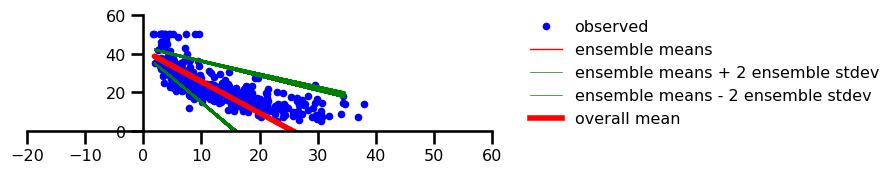

In [97]:
#@title Figure 4: Both Aleatoric & Epistemic Uncertainty
plt.figure(figsize=[6, 1.5])  # inches
plt.plot(x, y, 'b.', label='observed');

yhats = [model(x_tst) for _ in range(100)]
avgm = np.zeros_like(x_tst[..., 0])
for i, yhat in enumerate(yhats):
  m = np.squeeze(yhat.mean())
  s = np.squeeze(yhat.stddev())
  if i < 15:
    plt.plot(x_tst, m, 'r', label='ensemble means' if i == 0 else None, linewidth=1.)
    plt.plot(x_tst, m + 2 * s, 'g', linewidth=0.5, label='ensemble means + 2 ensemble stdev' if i == 0 else None);
    plt.plot(x_tst, m - 2 * s, 'g', linewidth=0.5, label='ensemble means - 2 ensemble stdev' if i == 0 else None);
  avgm += m
plt.plot(x_tst, avgm/len(yhats), 'r', label='overall mean', linewidth=4)

plt.ylim(-0.,60);
# plt.yticks(np.linspace(0, 15, 4)[1:]);
plt.xticks(np.linspace(*x_range, num=9));

ax=plt.gca();
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
ax.spines['left'].set_position(('data', 0))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
#ax.spines['left'].set_smart_bounds(True)
#ax.spines['bottom'].set_smart_bounds(True)
plt.legend(loc='center left', fancybox=True, framealpha=0., bbox_to_anchor=(1.05, 0.5))

# plt.savefig('tmp/housing.png', bbox_inches='tight', dpi=300)